## Fetch the data

In [83]:
#function to download the data into local 
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [21]:
def download_data(housing_url=housing_url,housing_path=housing_path):
    os.makedirs(housing_path,exist_ok=True)
    tgz_path=os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [23]:
def load_date(housing_path=housing_path):
    csv_path=os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

In [26]:
housing_pd=load_date()

In [27]:
housing_pd.shape

(20640, 10)

In [28]:
housing_pd.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [29]:
housing_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [52]:
housing_pd.isnull().sum()/housing_pd.shape[0]

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.010029
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

only 1 categorical feature and only total_bedroom has 1% of missing values

## EDA

In [30]:
housing_pd.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [47]:
#'mean'
housing_pd.groupby('ocean_proximity').agg({'median_house_value':np.mean}).reset_index().sort_values(by='median_house_value',ascending=False)

,ocean_proximity,median_house_value
2,ISLAND,380440.000000
3,NEAR BAY,259212.311790
4,NEAR OCEAN,249433.977427
0,<1H OCEAN,240084.285464
1,INLAND,124805.392001


In [31]:
housing_pd.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [79]:
#split numerical and categorical features and put into dictionary 
numer_features=housing_pd.columns.tolist()[:-1]
cate_features=housing_pd.columns.tolist()[-1]
feature_dict={'numer_features':numer_features,'cate_features':cate_features}
feature_dict

{'numer_features': ['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'median_house_value'],
 'cate_features': 'ocean_proximity'}

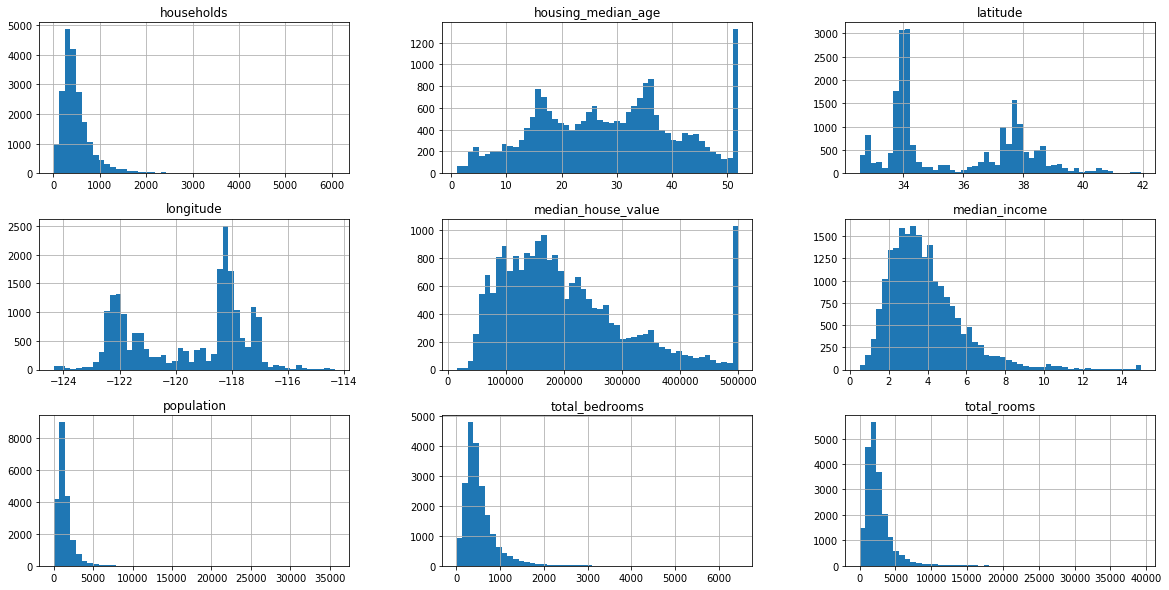

In [92]:
#plot dist for all numerical features
for i in [numer_features]:
    housing_pd[i].hist(bins=50,figsize=(20,10))
    plt.show()

-Different scales, should do feature scaling for some algorithms

-Some hist are tail heavy, hard for some algorithm to detect pattern, transform to more bell shaped distributions

-Should figure out the min income unit

## Create a test set

Make sure test set doesn't contain any instance that was previously in the training set, in order to achieve this:

-Set random generator'seed ( don't work if adding new instances )

-Use identifier ( eg if date eariler than 2020-01-01 go to train set and later than that go to test set )

In [129]:
def split_train_test(df,split_ratio):
    rand=np.random.permutation(range(df.shape[0]))
    train_rand=rand[:int(df.shape[0]*split_ratio)]
    test_rand=rand[int(df.shape[0]*split_ratio):]
    return df.iloc[train_rand],df.iloc[test_rand]

In [130]:
train_set,test_set=split_train_test(housing_pd,0.8)

In [133]:
train_set.shape,test_set.shape
#[i for i in list(train_rand) if not list(test_rand)]

((16512, 10), (4128, 10))

In [137]:
#sklearn has train_test split function
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(housing_pd,train_size=0.8,random_state=201)

In [138]:
train_set.shape,test_set.shape

((16512, 10), (4128, 10))

In [144]:
#change numeric feature to categorical since median_income is important to predict the housing price
#therefore in the test set that we want it to be appeared in the same proportion as in the train set
housing_pd['median_income_bin']=pd.cut(housing_pd['median_income'],bins=[0,1.5,3.0,4.5,6,np.inf],labels=[1,2,3,4,5])

In [145]:
housing_pd['median_income_bin'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: median_income_bin, dtype: int64

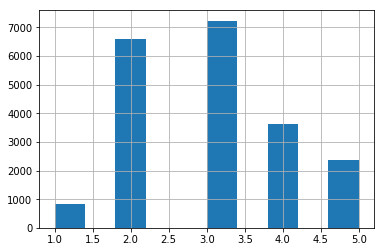

In [146]:
housing_pd['median_income_bin'].hist()

In [157]:
#start doing stratified sampling, preserving the percentage of samples for each class.
from sklearn.model_selection import StratifiedShuffleSplit
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=200)
for train_index,test_index in sss.split(housing_pd,housing_pd['median_income_bin']):
    train_set=housing_pd.iloc[train_index]
    test_set=housing_pd.iloc[test_index]

In [158]:
train_set.shape,test_set.shape

((16512, 11), (4128, 11))

In [162]:
housing_pd.median_income_bin.value_counts(normalize=True)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: median_income_bin, dtype: float64

In [161]:
test_set.median_income_bin.value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: median_income_bin, dtype: float64

## visual the data to gain insights

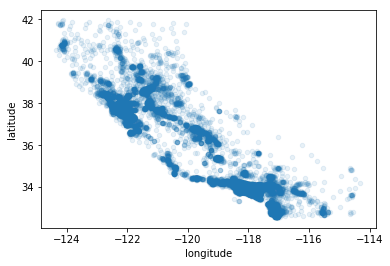

In [171]:
#visual geographical data
housing_pd.plot(kind='scatter',x='longitude',y='latitude')

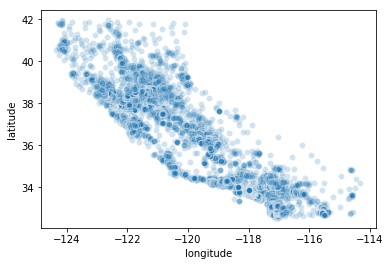

In [178]:
#using seaborn 
sns.scatterplot(housing_pd.longitude,housing_pd.latitude,alpha=0.2)

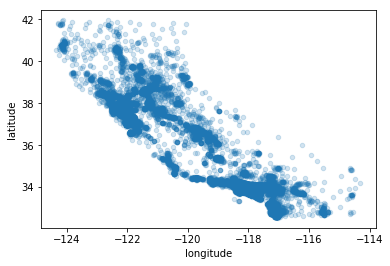

In [172]:
#better one with density highlights
housing_pd.plot(kind='scatter',x='longitude',y='latitude',alpha=0.2)

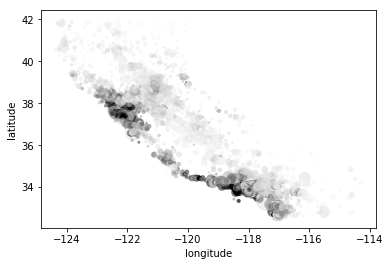

In [191]:
#add radius=population, color=price using matplotlib
housing_pd.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,c=housing_pd.median_house_value*10,s=housing_pd.population/100)

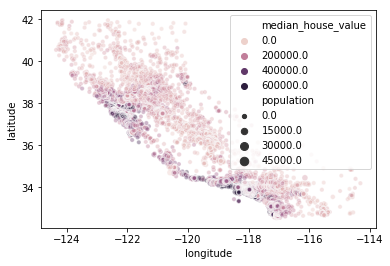

In [193]:
#add radius=population, color=pric using seaborn, we can see it doesn't even need to scale the population
sns.scatterplot(housing_pd.longitude,housing_pd.latitude,alpha=0.4,size=housing_pd.population,hue=housing_pd.median_house_value)

## Look for correlation

In [196]:
#standard correlation coefficient (only measure linear correlation), Pearson's r
housing_pd.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

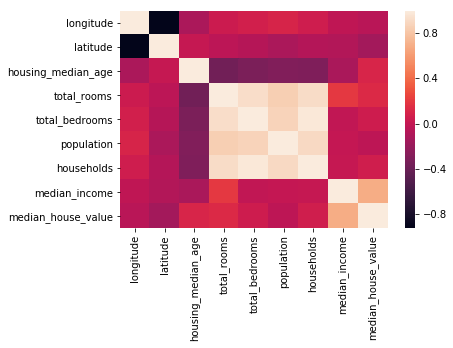

In [198]:
sns.heatmap(housing_pd.corr())

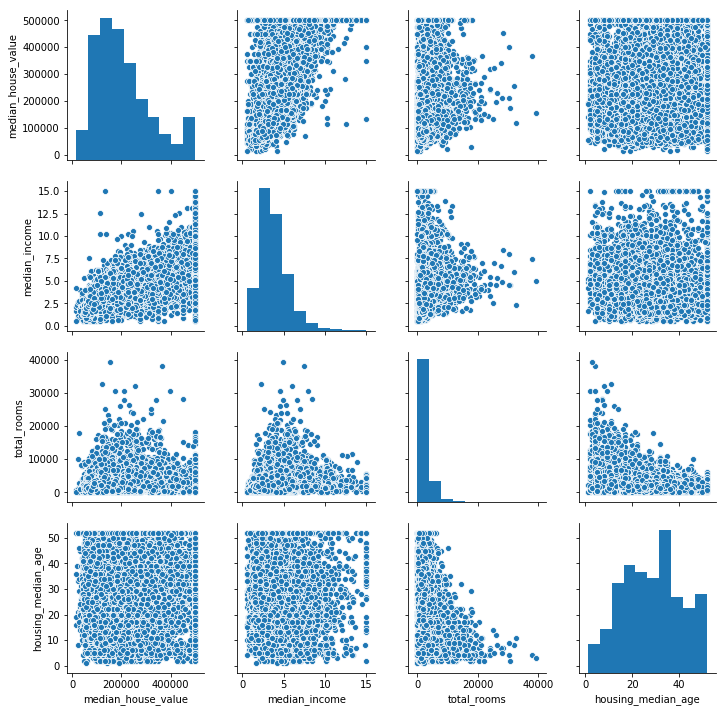

In [199]:
#how to evaluate feature correlation if not linear, check pair scatterplot
sns.pairplot(housing_pd[['median_house_value','median_income','total_rooms','housing_median_age']])

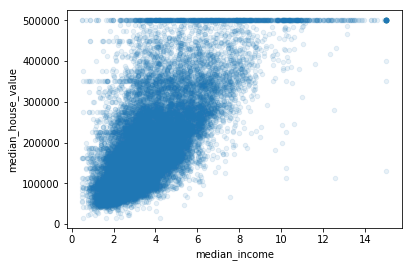

In [202]:
housing_pd.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.1)

## Experimenting with attribute combinations 

In [203]:
housing_pd['rooms_per_househould']=housing_pd['total_rooms']/housing_pd['households']

In [205]:
housing_pd.corr()['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688075
rooms_per_househould    0.151948
total_rooms             0.134153
housing_median_age      0.105623
households              0.065843
total_bedrooms          0.049686
population             -0.024650
longitude              -0.045967
latitude               -0.144160
Name: median_house_value, dtype: float64

## Data Preparation 